In [1]:
DATA_FOLDER = "../../random-data/"
OUTPUT_FOLDER = "../../deliverables/injected/"
WINDOW_SIZE = 1024 # size in freq bins of injected signal

In [2]:
import setigen as stg
import blimpy as bl
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy as dc

/home/obs/.conda/envs/seticore/lib/python3.10/site-packages/blimpy/__init__.py:21: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [3]:
fil_filename = 'guppi_60703_16858_008036_TIC286923464_ON_0001.0000.fil'

In [4]:
frame = stg.Frame(waterfall=DATA_FOLDER+fil_filename)

## Constant drifted

In [5]:
min_freq_index = 400
dr = 1.1 * u.Hz / u.s
snr = 25

l = 42_689_571 ; r = l + WINDOW_SIZE

In [6]:
def make_frame_s(min_freq_index, dr, snr, l, r):
    frame_s = frame.get_slice(l,r)
    signal = frame_s.add_signal(
        stg.constant_path(f_start=frame_s.get_frequency(index=min_freq_index),
                          drift_rate=dr),
        stg.constant_t_profile(level=frame.get_intensity(snr=snr)),
        stg.gaussian_f_profile(width=100*u.Hz),
        stg.constant_bp_profile(level=1)
    )
    return frame_s

In [7]:
frame_s = make_frame_s(min_freq_index, dr, snr, l, r)

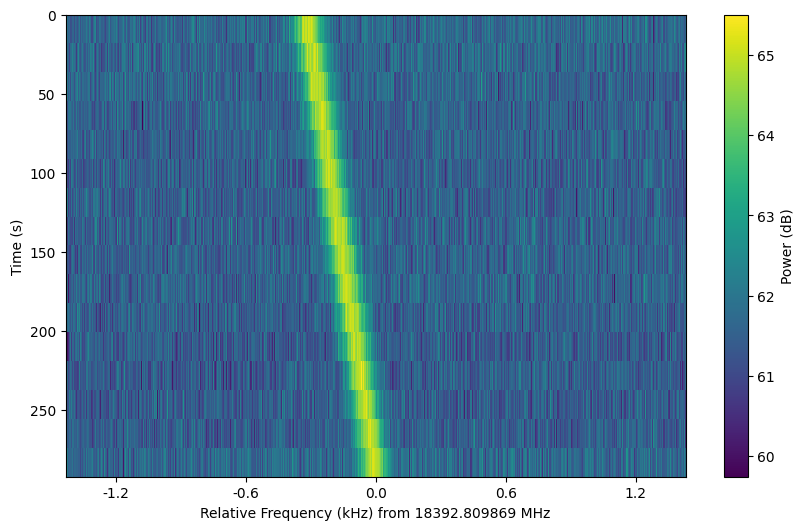

In [8]:
fig = plt.figure(figsize=(10,6))
frame_s.plot(db=True)

In [9]:
def modify_and_save(frame_s, frame, l, r, adj=""): 
    old_data = dc(frame.data)
    frame.data[:, l:r] = frame_s.data
    frame.save_h5(OUTPUT_FOLDER + fil_filename[:-4] + f"{'.' + adj if adj!='' else ''}.h5")
    frame.data = dc(old_data)

In [10]:
modify_and_save(frame_s, frame, l, r)

blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for ../../deliverables/injected/guppi_60703_16858_008036_TIC286923464_ON_0001.0000.h5 without blobbing.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
blimpy.waterfall INFO     Conversion time: 5.00sec


I tried running both the file with the added signal and the one without using `seticore`, and the result is the same. I could try increasing the SNR either here or in `seticore`. It would be easier with the latter, but I'm doing it from here because even if it takes longer, it will be easier to check the differences afterward.

In [11]:
frame_s = make_frame_s(min_freq_index, dr, 2*snr, l, r)
modify_and_save(frame_s, frame, l, r, "strong")

blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for ../../deliverables/injected/guppi_60703_16858_008036_TIC286923464_ON_0001.0000.strong.h5 without blobbing.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
blimpy.waterfall INFO     Conversion time: 5.15sec


In [12]:
frame_s = make_frame_s(400, 5 * u.Hz / u.s, 1e3, l, r)
modify_and_save(frame_s, frame, l, r, "mighty")

blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for ../../deliverables/injected/guppi_60703_16858_008036_TIC286923464_ON_0001.0000.mighty.h5 without blobbing.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
blimpy.waterfall INFO     Conversion time: 5.44sec


## Weird

In [13]:
from utils.osea_signal import osea_path as osea_path

In [14]:
frame_s = frame.get_slice((l := 42_689_571), (r := l + WINDOW_SIZE))

In [15]:
signal = frame_s.add_signal(
    osea_path(f_start=frame_s.get_frequency(index=200),
              drift_rate=3, 
              amplitude=1_000,
              omega=0.07,
              mu=0.005),
    stg.constant_t_profile(level=frame.get_intensity(snr=20)),
    stg.gaussian_f_profile(width=100*u.Hz),
    stg.constant_bp_profile(level=1)
)

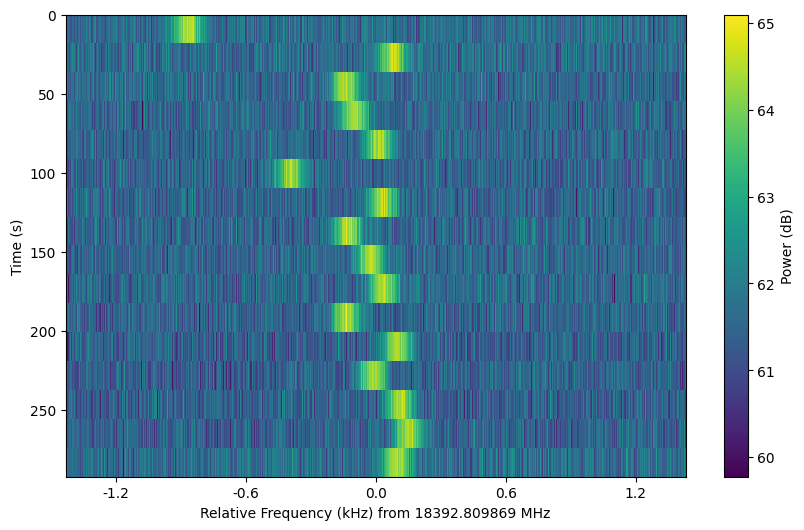

In [16]:
fig = plt.figure(figsize=(10,6))
frame_s.plot(db=True)

In [17]:
modify_and_save(frame_s, frame, l, r, "weird")

blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for ../../deliverables/injected/guppi_60703_16858_008036_TIC286923464_ON_0001.0000.weird.h5 without blobbing.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
blimpy.waterfall INFO     Conversion time: 5.43sec
